In [275]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import mean_squared_error
# from google.colab import drive
import os
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import v2
import torch.nn.functional as F
import torchvision

In [295]:

device = torch.device('cuda')
# cnn = nn.Sequential(
#     nn.Conv2d(1, 4,20),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),
#     nn.Conv2d(4, 8,10),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),
#     nn.Conv2d(8, 16,6),
#     nn.ReLU(),
#     nn.Conv2d(16, 32,6),
#     nn.MaxPool2d(2,2),
#     nn.ReLU(),
#     nn.Conv2d(32, 32,4),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),
#     nn.Flatten(),
#     nn.Linear(2592,200),
#     nn.ReLU(),
#     nn.Linear(200,1),
# ).to(device)
cnn = nn.Sequential(
    nn.Conv2d(1, 8,6),
    nn.ReLU(),
    nn.Conv2d(8, 16,6),
    nn.MaxPool2d(2,2),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(16, 32,4),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Linear(128,60),
    nn.ReLU(),
    nn.Linear(60,1),
).to(device)

class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None, output='p'):
        self.image_list = os.listdir(img_dir)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.output = output

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_list[idx])
        image = read_image(img_path)
        p, N = self.image_list[idx].split("_")
        p = np.float32(p)
        N = np.float32(N.split('.')[0])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        if self.output == 'p':
            return image, torch.tensor([p])
        return image, torch.tensor([rescale_N(N)])

def rescale_N(N):
    return np.float32(np.log(N)/10)
def undo_rescale_N(N):
    return np.float32(np.exp(N*10))

transforms = v2.Compose([
    v2.RandomCrop(40),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
])
dataset = ImageDataset("perco_image", transform=transforms, output='N')

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

epochs = 50

train_loss = []
test_loss = []
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
loss_function = torch.nn.MSELoss()
for epoch in range(epochs):  # loop over the dataset multiple times
    cnn.train()
    epoch_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        imgs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = cnn(imgs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        epoch_loss += loss.item()
        if i % 5 == 4:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 5:.3e}')
            running_loss = 0.0
    train_loss.append(epoch_loss/len(train_dataloader))
    
    cnn.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_dataloader):
            imgs, labels = data[0].to(device), data[1].to(device)
            outputs = cnn(imgs)
            loss = loss_function(outputs, labels)
            epoch_loss += loss.item()
        test_loss.append(epoch_loss/len(test_dataloader))  
    
print('Finished Training')


[1,     5] loss: 3.575e-01
[1,    10] loss: 3.709e-01
[1,    15] loss: 3.384e-01
[2,     5] loss: 2.977e-01
[2,    10] loss: 2.415e-01
[2,    15] loss: 2.309e-01
[3,     5] loss: 1.656e-01
[3,    10] loss: 1.025e-01
[3,    15] loss: 6.980e-02
[4,     5] loss: 4.689e-02
[4,    10] loss: 4.554e-02
[4,    15] loss: 4.737e-02
[5,     5] loss: 3.893e-02
[5,    10] loss: 3.544e-02
[5,    15] loss: 3.565e-02
[6,     5] loss: 3.076e-02
[6,    10] loss: 2.821e-02
[6,    15] loss: 2.226e-02
[7,     5] loss: 2.124e-02
[7,    10] loss: 1.678e-02
[7,    15] loss: 1.424e-02
[8,     5] loss: 1.150e-02
[8,    10] loss: 8.671e-03
[8,    15] loss: 7.840e-03
[9,     5] loss: 7.143e-03
[9,    10] loss: 5.299e-03
[9,    15] loss: 4.547e-03
[10,     5] loss: 4.167e-03
[10,    10] loss: 3.780e-03
[10,    15] loss: 3.648e-03
[11,     5] loss: 4.038e-03
[11,    10] loss: 3.489e-03
[11,    15] loss: 3.401e-03
[12,     5] loss: 3.547e-03
[12,    10] loss: 3.144e-03
[12,    15] loss: 3.245e-03
[13,     5] loss: 3

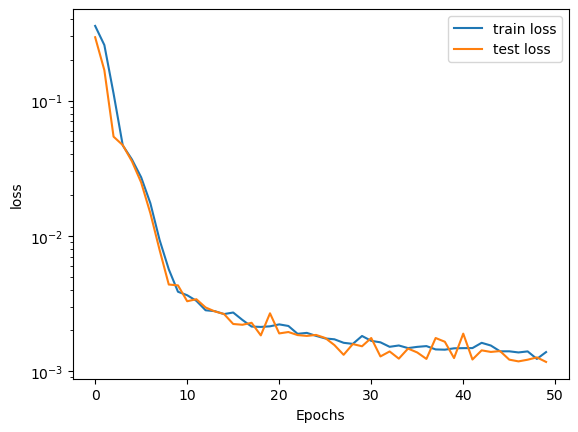

In [296]:
import matplotlib.pyplot as plt
plt.plot(np.arange(epochs), train_loss, label='train loss')
plt.plot(np.arange(epochs), test_loss, label='test loss')
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [336]:
def undo_rescale_N(N):
    return torch.exp(N*10)

y_pred = []
y_true = []
cnn.eval()
epoch_loss = 0
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        imgs, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(imgs)
        y_true.extend(list(undo_rescale_N(labels).detach().cpu().numpy().flatten()))
        print(list(undo_rescale_N(cnn(imgs)).detach().cpu().numpy().flatten()))
        y_pred.extend(list(undo_rescale_N(cnn(imgs)).detach().cpu().numpy().flatten()))


[2396.8413, 476.0644, 267.27277, 59684.645, 62167.47, 58105.273, 263.1834, 65829.09, 77.34641, 7.0112176, 48285.074, 30840.973, 146.50082, 4.274529, 34.41496, 213.12064, 46138.887, 49661.082, 27924.396, 1170.5226, 71.90534, 1557.8586, 329.4449, 7.7590513, 58955.832, 27372.932, 66553.31, 47.057022, 224.3875, 108.877014, 92.03458, 7260.33, 26331.523, 63558.574, 62936.344, 17325.512, 16.518784, 45.646923, 33094.035, 76.18846, 19152.242, 30.668224, 89.4585, 12768.369, 105.32076, 19.148378, 59618.535, 65.215965, 20695.541, 809.2843, 162.56195, 53830.824, 920.1137, 50897.266, 41010.44, 66709.89, 55050.387, 23316.049, 1333.1523, 35.972702, 77.827965, 19.612473, 58287.93, 44656.18]
[3.175574, 137.80399, 56825.4, 65526.754, 10.651172, 70.3758, 78.442154, 126.89681, 46.22485, 51.135757, 49427.715, 12026.479, 136.74638, 5.053612, 66425.734, 34.036255, 40.289608, 39.557747, 211.58922, 34142.727, 31.948606, 260.74063, 1708.9379, 13.8909, 4018.738, 66924.95, 73.300476, 9.500009, 151.24266, 13442.953

In [337]:
# undo_rescale_N(labels).detach().cpu().numpy().flatten()
len(y_pred)

228

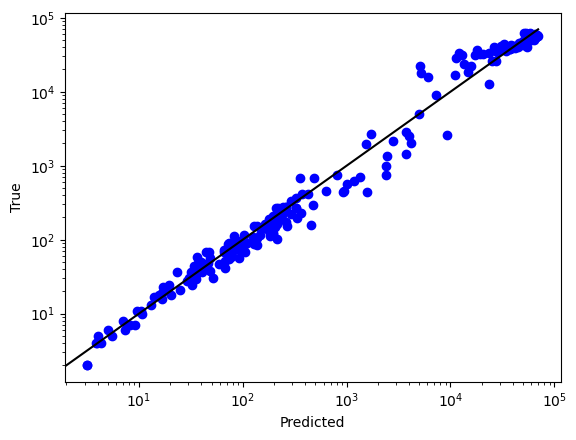

In [344]:
plt.scatter(y_pred,y_true, c='b')
plt.plot([0,max(y_pred)],[0,max(y_pred)],c='k')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.yscale('log')
plt.xscale('log')